In [1]:
import pyEDITH as pE
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
os.environ["YIP_CORO_DIR"] = "/Users/mhcurrie/science/packages/yippy/yips/"

/Users/mhcurrie/science/packages/Sci-Eng-Interface/hwo_sci_eng


# Testing pyEDITH spectroscopy mode

## Set up a parameters dictionary

In [31]:
# this is where all the input parameters are stored for EDITH
parameters = {}


## Set up the observation object. Eventually, this is where the exposure time or SNR will be placed after calculation. 

In [ ]:
# to set up the observation object, we need to specify a few overarching parameters:
parameters["wavelength"] = np.linspace(0.5, 1.5, 100) # define a wavelength grid in microns
parameters["nlambd"] = len(parameters["wavelength"]) # number of wavelengths
parameters["resolution"] = 5 # define a spectral resolution NOTE: not used for spectroscopy mode 
parameters["snr"] = 5*np.ones_like(parameters["wavelength"]) # the SNR you want for each spectral bin 
parameters["photap_rad"] = 0.85 # radius of the photometric aperture in units of lambda/D
parameters["CRb_multiplier"] = 2. # factor to multiply the background by (used for differential imaging)

#NOTE: there are more parameters we can define (see below), but these are the basics for now.


observation = pE.Observation() # define the observation object
observation.load_configuration(parameters) # load the specified configuration in the parameters dict 
observation.set_output_arrays()
observation.validate_configuration()

print(f"All params in Observation():")
for key in observation.__dict__.keys():
    print("-->", key)


All params in Observation():
--> td_limit
--> nooptimize
--> optimize_phase
--> ntot
--> nmeananom
--> norbits
--> lambd
--> SR
--> SNR
--> photap_rad
--> CRb_multiplier
--> nlambd
--> tp
--> exptime
--> fullsnr


## Set up the astrophysical scene

### First let's do something dumb and model the star/planet as blackbodies for testing

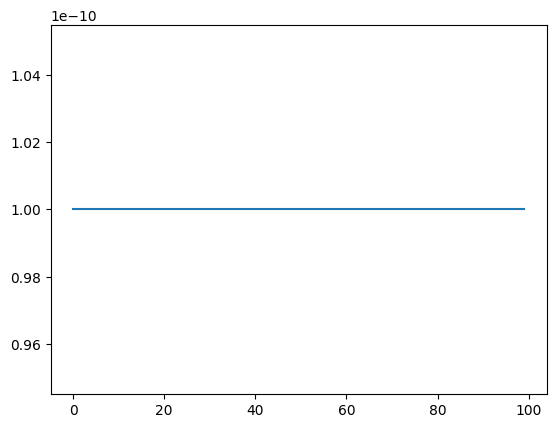

In [ ]:
from synphot import units, SourceSpectrum
from synphot.models import BlackBodyNorm1D
import astropy.units as u 
import astropy.constants as c 

def compute_blackbody_photon_flux(temp, wavelengths):
    """Generate photon flux density (photon/s/cm^2/um) for a blackbody at 1 cm^2."""
    bb = SourceSpectrum(BlackBodyNorm1D, temperature=temp)

    flux_photlam = bb(wavelengths).value * 1/(u.s * u.cm**2 * u.AA) # photons/s/cm2/A
    flux_photlam = flux_photlam.to(1 / (u.s * u.cm**2 * u.um)) # convert to 1/um

    return flux_photlam

def compute_star_flux_observed(stellar_flux_surface, R_star, dist):
    """Scale stellar surface flux to observer distance."""
    scale = (R_star / d_obs)**2
    return stellar_flux_surface * scale.decompose()

Tstar = 5800 * u.K
R_star = 1.0 * u.R_sun
dist = 1 * u.pc
scalar = ((R_star/dist)**2).decompose()

Fstar = compute_blackbody_photon_flux(Tstar, parameters["wavelength"]*u.um)
Fstar_obs = Fstar*scalar
contrast = 1e-10
Fplan_obs = Fstar_obs*contrast
FpFs = Fplan_obs / Fstar_obs
plt.plot(FpFs)

In [ ]:
# we need several more parameters to define the astrophysical scene. These include parameters related to the star, planet, zodi/exozodi

# As an example, lets take the star HD 102365. It is a sun-like star (spectral type G2V) ~10 pc away. 
# It is also a Tier A target star from the NASA ExEP HWO target star list. 

# STAR
parameters["Lstar"] = 1. # luminosity of the star in solar luminosities
parameters["distance"] = 10. # distance to the system in pc
# Note: we can work in either mag or flux units. Let's choose to work in flux units. 

parameters["angdiam"] = 0.01 # angular diameter of the star in arcsec

# parameters["Fstar"] = Fstar_obs.value # Fstar modeled as a blackbody (see above)
# parameters["FstarV"] = 5.84 # V-band flux of the star 
# parameters["Fp/Fs"] = FpFs
# parameters["Fp_min/Fs"] = 1e-11 # minimum detectable planet 

parameters["magV"] = 5.84
parameters["mag"] = 6.189576 * np.ones_like(parameters["wavelength"]) # assume a flat spectrum for now 
parameters["delta_mag"] = 20 * np.ones_like(parameters["wavelength"]) # originally 25.5 assume a flat spectrum for now
parameters["delta_mag_min"] = 26.



parameters["nzodis"] = 3. # number of zodis for exozodi estimate
parameters["ra"] = 176.6292 # approximate ra of HD 102365. WARNING: do not use this number for science. 
parameters["dec"] = -40.5003 # approximate dec of HD 102365. WARNING: do not use this number for science. 

# PLANET
parameters["separation"] = 0.1 # planetary separation in arcsec

scene = pE.AstrophysicalScene()
scene.load_configuration(parameters)
scene.calculate_zodi_exozodi(observation)
scene.validate_configuration()
print("Parameters that the scene object carries:")
for key in scene.__dict__.keys():
    print("-->", key)
, scene.__dict__.keys())

Parameters that the scene object carries:
--> F0V
--> ntargs
--> Lstar
--> dist
--> F0
--> vmag
--> mag
--> deltamag
--> min_deltamag
--> Fstar
--> Fp0
--> Fp0_min
--> angdiam_arcsec
--> nzodis
--> ra
--> dec
--> sp
--> xp
--> yp
--> M_V
--> Fzodi_list
--> Fexozodi_list
--> Fbinary_list


'scene.__dict__.keys())'

## Set up the observatory: telescope, coronagraph, detector

In [ ]:
# Create and configure Observatory using ObservatoryBuilder.
# This compiles the telescope, coronagraph, and detector and places them all in a single object. 
# These parameters mostly come from the EAC YAML files, but we have to specify a few:

parameters["observatory_preset"] = "EAC1" # tells ETC to use EAC1 yaml files throughputs
parameters["observing_mode"] = "IFS" # tells ETC to use spectroscopy (IFS) mode
parameters["IFS_eff"]  = 1. # extra throughput of the IFS 
parameters["npix_multiplier"] = np.ones_like(parameters["wavelength"]) # number of detector pixels per spectral bin
parameters["noisefloor_factor"] = 0#0.03 # estimate the noisefloor as a multiplicative term on the on-axis coronagraph response for the star

observatory_config = pE.parse_input.get_observatory_config(parameters)
observatory = pE.ObservatoryBuilder.create_observatory(observatory_config)
pE.ObservatoryBuilder.configure_observatory(
    observatory, parameters, observation, scene
)
observatory.validate_configuration()
print("Parameters in observatory:")
for key in observatory.__dict__.keys():
    if key in ["telescope", "coronagraph", "detector"]:
        print("-->", key)
        subkeys = observatory.__dict__[key].__dict__.keys()
        for subkey in subkeys:
            print("    -->", subkey)
    else:
        print("-->",key)


Observatory Configuration:
  Using preset: EAC1



[yippy] INFO [2025-04-10 14:12:44,418] Creating usort_offaxis_ovc coronagraph
[yippy] WARNING [2025-04-10 14:12:44,419] Unhandled header fields: {'D_INSC'}
[yippy] WARNING [2025-04-10 14:12:44,420] Using default unit for D: m. Could not extract unit from comment: "circumscribed diameter of the telescope in mete"
[yippy] INFO [2025-04-10 14:12:44,454] usort_offaxis_ovc is radially symmetric
[yippy] INFO [2025-04-10 14:12:44,467] Created usort_offaxis_ovc


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Calculating optics throughput from preset...
Calculating epswarmTrcold as 1 - optics throughput...
Parameters in observatory:
--> telescope
    --> path
    --> keyword
    --> diameter
    --> unobscured_area
    --> toverhead_fixed
    --> toverhead_multi
    --> telescope_throughput
    --> Tcontam
    --> temperature
    --> Area
--> detector
    --> path
    --> keyword
    --> pixscale_mas
    --> npix_multiplier
    --> DC
    --> RN
    --> tread
    --> CIC
    --> QE
    --> dQE
--> coronagraph
    --> path
    --> keyword
    --> bandwidth
    --> pixscale
    --> minimum_IWA
    --> maximum_OWA
    --> contrast
    --> noisefloor_factor
    --> nrolls
    --> psf_trunc_ratio
    --> coronagraph_throughput
    --> nchannels
    --> TLyot
    --> npix
    --> xcenter
    --> ycenter
    --> skytrans
    --> r
    --> npsfr

## Let's take a look at some of the observatory parameters:

### Total throughput from primary mirror to just before the detector:

Text(0.5, 1.0, 'Total Throughput')

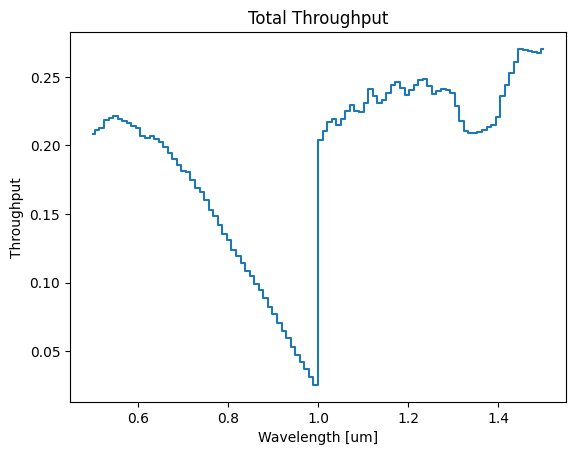

In [ ]:
plt.figure()
plt.step(observation.wavelength, observatory.total_throughput, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Throughput")
plt.title("Total Throughput")

### Why does throughput nosedive to 1. um?
This has to do with the assumed visible QE (see below)

Initializing Coronagraph Instrument
Loading file: /obs_config/CI/CI.yaml

Optical path:
['PM', 'SM', 'TCA', 'TCA', 'TCA', 'TCA', 'wave_beamsplitter', 'pol_beamsplitter', 'FSM', 'OAPs_forward', 'OAPs_forward', 'DM1', 'DM2', 'OAPs_forward', 'Fold', 'OAPs_back', 'Apodizer', 'OAPs_back', 'Focal_Plane_Mask', 'OAPs_back', 'Lyot_Stop', 'OAPs_back', 'Field_Stop', 'OAPs_back', 'filters', 'OAPs_back', 'Detector', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless', 'unitless']
Calculating throughput...
Calculating instrument throughput...
--including TCA
--including TCA
--including TCA
--including TCA
--including wave_beamsplitter
--including pol_beamsplitter
--including FSM
--including OAPs_forward
--including OAPs_forward
--including DM1
-

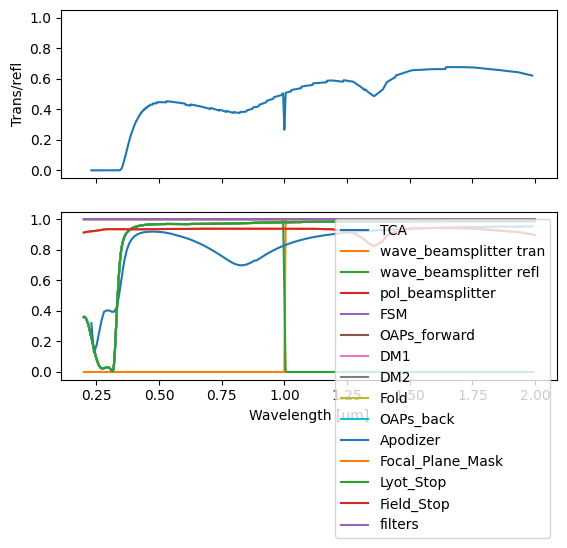

Loading IFS...


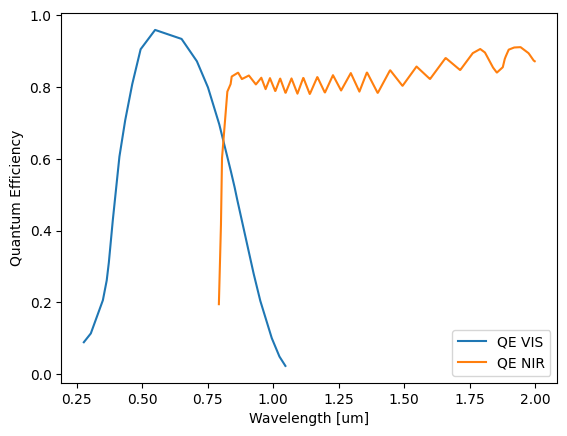

VISIBLE
-------
RN: 0.0
DC: 3e-05


NIR
---
RN: 0.4
DC: 0.0001


In [77]:
# to answer this, let's look in the YAML files for EAC1.
import eacy
eacy.load_instrument("CI", plotting=True, verbose=True) # load the coronagraph instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot. 
eacy.load_detector("IFS", plotting=True, verbose=True) # load the detector instrument given in the yaml files. This also calculates the throughput, and we can tell it to plot.

### Coronagraph response maps

/Users/mhcurrie/miniforge3/envs/test_eacy/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Coronagraph skytrans')

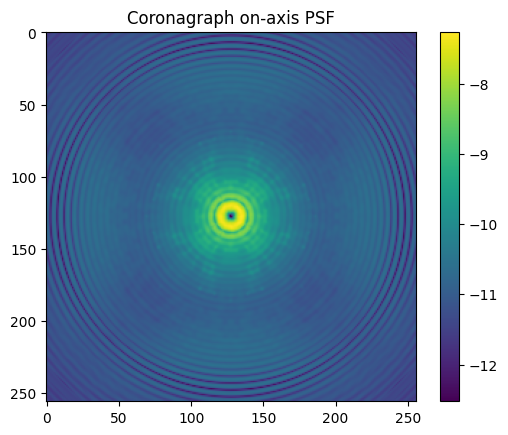

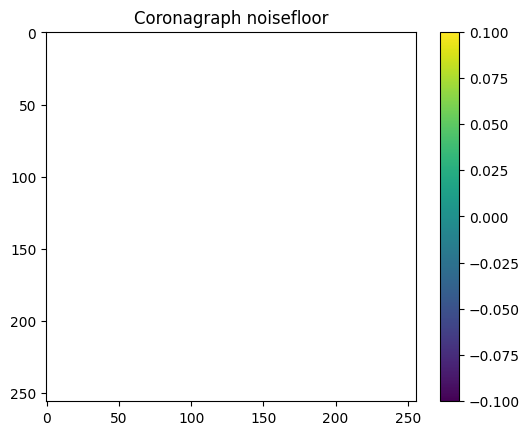

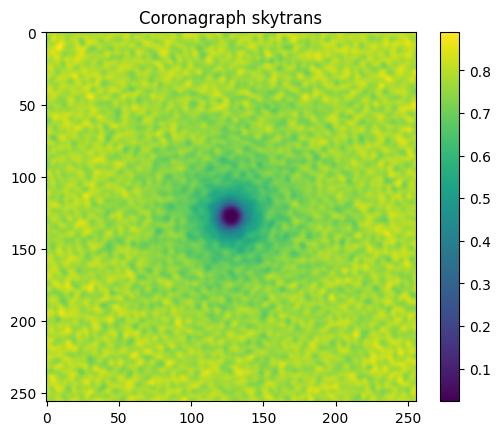

In [38]:
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("Coronagraph on-axis PSF")

plt.figure()
plt.imshow(np.log10(observatory.coronagraph.noisefloor))
plt.colorbar()
plt.title("Coronagraph noisefloor")

plt.figure()
plt.imshow(observatory.coronagraph.skytrans)
plt.colorbar()
plt.title("Coronagraph skytrans")



## Before running the ETC, let's take a look at some of the inputs:

/var/folders/76/44nxzlz96gq60009v_1__gp4vmc5t3/T/ipykernel_67862/3523267893.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


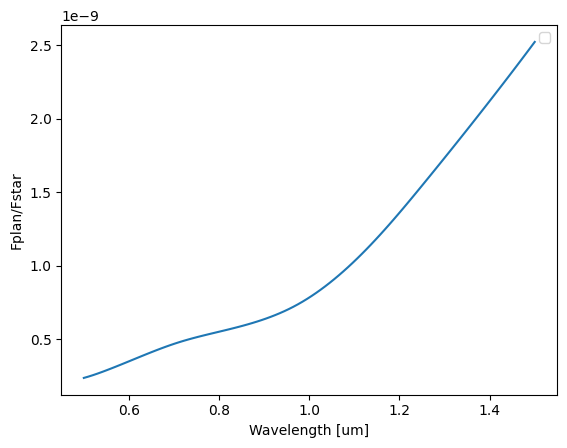

In [ ]:
plt.figure()

plt.plot(observation.wavelength, getattr(scene, "Fp0")/(getattr(scene, "F0")*getattr(scene, "Fstar")))
plt.xlabel("Wavelength [um]")
plt.ylabel("Fplan/Fstar")
plt.legend()


## Finally, let's run the exposure time calculation:
### After running, the calculated exposure times will be an attribute (exptime) of the pyEDITH object. 

In [40]:
pE.calculate_exposure_time_or_snr(observation, scene, observatory, verbose=False)

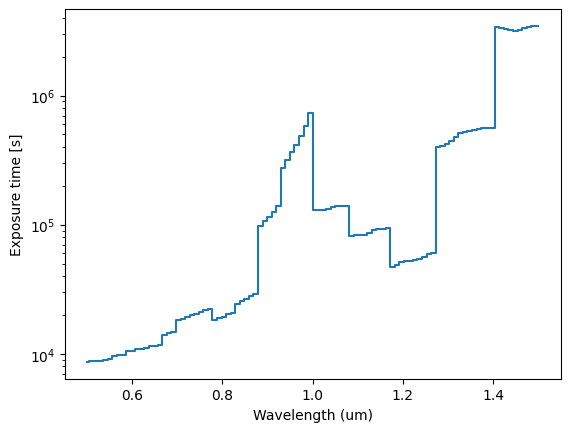

In [ ]:
# Let's plot it:
plt.figure()
plt.step(observation.wavelength, observation.exptime, where="mid")
plt.ylabel("Exposure time [s]")
plt.xlabel("Wavelength (um)")

plt.yscale("log")

## We can also plot the individual photon counts to see if we're getting something reasonable.

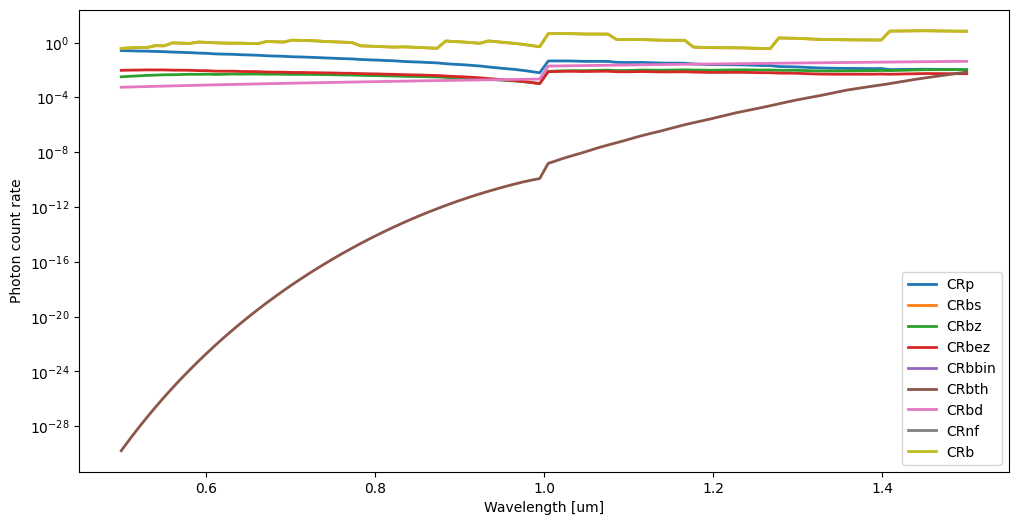

In [ ]:
photon_counts = pickle.load(open("./photon_counts.pk", "rb"))
plt.figure(figsize=(12,6))
for key in photon_counts.keys():
    #print(key)
    #print(photon_counts[key])
    plt.plot(observation.wavelength, photon_counts[key], label=key, lw=2)
plt.yscale("log")
plt.ylabel("Photon count rate")
plt.xlabel("Wavelength [um]")
plt.legend()

## Why does the exposure time look blocky?
This has to do with the on-axis coronagraph response map (Istar). The planet is at a fixed separation in arcsec space, but the location is not fixed in lambda/D space. The planet appears to move closer to the star in lambd/D space with increasing wavelength, thus it experiences a different coronagraphic response. Since the on-axis PSF map is sampled at 0.25 lod, this limits our resolution for the contrast as a function of planet separation. 

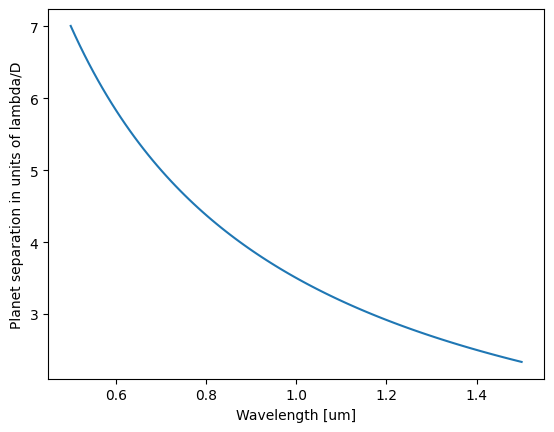

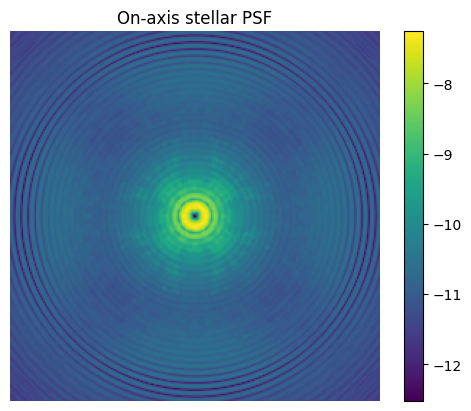

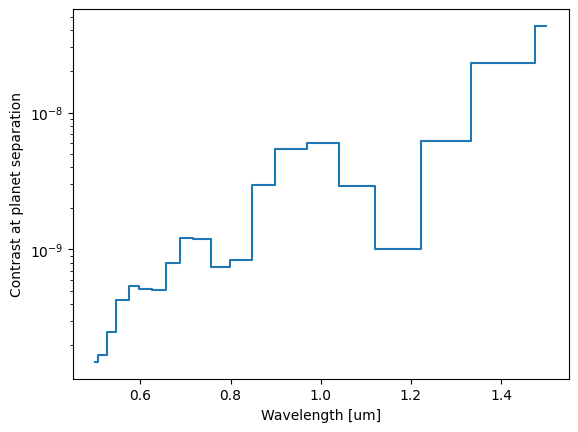

In [ ]:
planet_separation_arcsec = scene.separation
planet_separation_rad = planet_separation_arcsec.to(u.rad)
tel_diam = observatory.telescope.diameter

wavelengths = observation.wavelength
planet_separation_lod = (planet_separation_rad.value * tel_diam) / wavelengths.to(u.m) 
plt.figure()
plt.plot(wavelengths, planet_separation_lod)
plt.xlabel("Wavelength [um]")
plt.ylabel("Planet separation in units of lambda/D")

# Let's revisit the on-axis stellar PSF map
plt.figure()
plt.imshow(np.log10(observatory.coronagraph.Istar))
plt.colorbar()
plt.title("On-axis stellar PSF")
plt.gca().axis("off")


# Now let's plot the coronagraphic response as a function of planetary separation
cgcenter = (observatory.coronagraph.npix - 1) / 2
cg_pixscale = 0.25 # lod units

planetary_separation_pix = planet_separation_lod/cg_pixscale + cgcenter

contrast_at_planet_sep = []
for sep in planetary_separation_pix:
    sepx = int(np.floor(sep))
    sepy = int(np.floor(cgcenter))
    contrast_at_planet_sep.append(observatory.coronagraph.Istar[sepy, sepx])

plt.figure()
plt.step(wavelengths, contrast_at_planet_sep, where="mid")
plt.xlabel("Wavelength [um]")
plt.ylabel("Contrast at planet separation")
plt.yscale("log")

